# Comparison of Machine Learning Models for Sentiment Analysis
- Random Forest
- Support Vector Classification (SVC)
- Multinomial Naive Bayes
- Logistic Regression

In [50]:
# import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
#from xgboost import XGBClassifier # maybe excluse this

In [2]:
# load data
tweet_sentiments_df = pd.read_csv('resources/dataset/tweet_sentiments_consolidated.csv')
tweet_sentiments_df.head()

,location,tweetcreatedts,text,country,neg,neu,pos,compound,sentiment
0,India,2022-03-01,urges government to rescue student along wit...,india,0.000,0.769,0.231,0.5106,positive
1,"Stoney Creek, Ontario",2022-03-01,moscow underground sometimes the act of resis...,canada,0.000,0.880,0.120,0.3818,positive
2,"Los Angeles, CA",2022-03-01,via video game industry shares support for u...,usa,0.219,0.506,0.275,0.0000,neutral
3,Australia,2022-03-01,tomlinson had planned stops in kyiv on july ...,australia,0.127,0.873,0.000,-0.1531,negative
4,Ukraine,2022-03-01,stop russian aggression against close the ...,ukraine,0.320,0.558,0.122,-0.4404,negative


In [3]:
# check the count of the sent_score where Negative, Positive, Neutral
tweet_sentiments_df["sentiment"].value_counts()

negative    448490
positive    359758
neutral     156081
Name: sentiment, dtype: int64

In [5]:
# Dropping all neutral sentiments to generalize the model
tweet_sentiments_df = tweet_sentiments_df[tweet_sentiments_df["sentiment"]!="neutral"]

In [6]:
# Creating encoded column for sentiments by using .factorize() function in panda encode the object as an 
#enumerated type or categorical variable. 
tweet_sentiments_df["sent_score"] = tweet_sentiments_df["sentiment"].factorize()[0]
tweet_sentiments_df.head()

,location,tweetcreatedts,text,country,neg,neu,pos,compound,sentiment,sent_score
0,India,2022-03-01,urges government to rescue student along wit...,india,0.000,0.769,0.231,0.5106,positive,0
1,"Stoney Creek, Ontario",2022-03-01,moscow underground sometimes the act of resis...,canada,0.000,0.880,0.120,0.3818,positive,0
3,Australia,2022-03-01,tomlinson had planned stops in kyiv on july ...,australia,0.127,0.873,0.000,-0.1531,negative,1
4,Ukraine,2022-03-01,stop russian aggression against close the ...,ukraine,0.320,0.558,0.122,-0.4404,negative,1
5,India,2022-03-01,the crisis has forced the us and the europ...,india,0.197,0.764,0.039,-0.8020,negative,1


In [7]:
# get random sample 
sample_df = tweet_sentiments_df.groupby('sent_score').sample(frac=.01)
sample_df.shape

(8083, 10)

In [8]:
# Standardize sentiment score distribution
sample_df["sent_score"].value_counts(normalize=True)

1    0.554868
0    0.445132
Name: sent_score, dtype: float64

In [9]:
# define independent and dependent variables
X=sample_df['text']
y=sample_df['sent_score']

In [10]:
# split the data into train and test
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=.8, random_state=42)

## TF-IDF (Term Frequency-Inverse Document Frequency)
It measures how many times a term exists in a document and gives less weight to most frequent terms, as those terms will probably be unhelpful in categorizing the dataset.

In [11]:
# Instantiate and fit TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2),
                             stop_words='english')

In [12]:
# Transform text into numeric vectors
X_train_tf= vectorizer.fit_transform(X_train.reset_index()["text"]).toarray()
X_test_tf = vectorizer.transform(X_test.reset_index()["text"]).toarray()

In [13]:
X_train_tf.shape

(6466, 8391)

## Compare Models

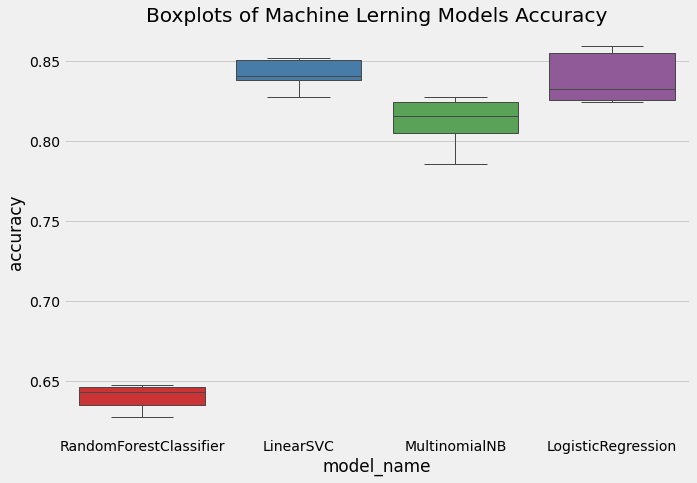

In [35]:
# run data over various models
models = [
    RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# plot boxplots of models accuracy
plt.subplots(figsize = (10,7))
plt.title('Boxplots of Machine Lerning Models Accuracy')
sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette="Set1", linewidth=1)

plt.show()

# From: https://github.com/HudaKas/Twitter-Sentiment-Analysis/blob/main/tweet%20analaysis.ipynb
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [31]:
# check the mean of the accuracy for each model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.841941
LogisticRegression        0.839620
MultinomialNB             0.811783
RandomForestClassifier    0.639807
Name: accuracy, dtype: float64

## Implement Linear SVC

In [45]:
# define and fit Linear SVC model
model = LinearSVC()
model.fit(X_train_tf, y_train)

LinearSVC()

In [46]:
# predict outcome using model
y_pred = model.predict(X_test_tf)
predictions = pd.DataFrame({
   "Prediction": y_pred,
   "Actual": y_test
}).reset_index(drop=True)
predictions.head()

,Prediction,Actual
0,1,0
1,1,1
2,1,1
3,0,0
4,1,1


In [47]:
# evaluate model
accuracy_score(y_test, y_pred)

0.8373531230674088

In [48]:
# print confusion matrix and classification report
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       723
           1       0.84      0.87      0.85       894

    accuracy                           0.84      1617
   macro avg       0.84      0.83      0.83      1617
weighted avg       0.84      0.84      0.84      1617



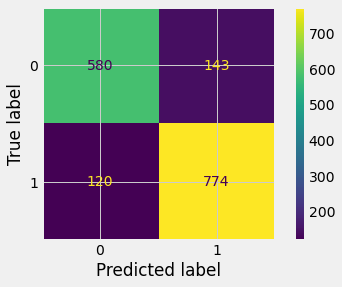

In [52]:
# plot test confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Feaure Importance
from: https://github.com/HudaKas/Twitter-Sentiment-Analysis/blob/main/tweet%20analaysis.ipynb

In [53]:
# Referred the below link to plot Most important features(words) within the model
#https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d#:~:text=Once%20a%20linear%20SVM%20is,can%20be%20accessed%20with%20svm.&text=The%20absolute%20size%20of%20the,for%20the%20data%20separation%20task.

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

/Users/floramatos/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


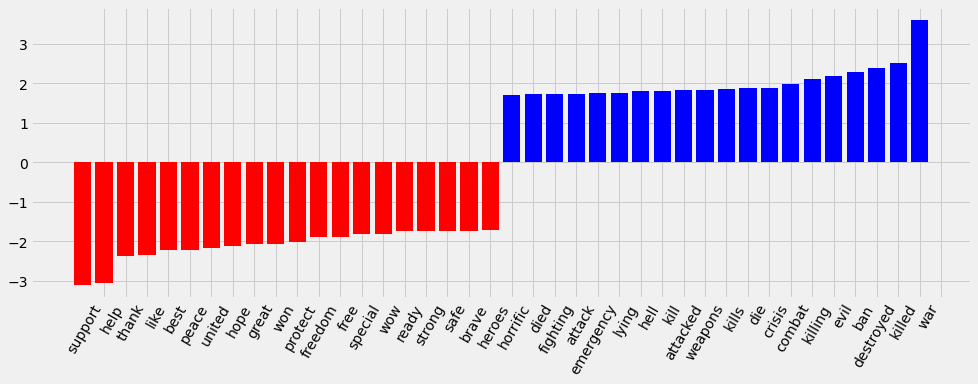

In [55]:
feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
df_feat=pd.DataFrame(coefs_with_fns)
df_feat.columns='coefficient','word'
df_feat.sort_values(by='coefficient')
plot_coefficients(model, feature_names)
#plt.savefig("images/.png")